In [1]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
use_unet = False
if use_unet: import unet as autoencoder
else: import autoencoder2 as autoencoder

In [3]:
base_dir = os.path.join('Plant_leave_diseases_dataset', 'original')
images_paths = []

In [4]:
# Load the encoder model
def load_encoder(model_path, device):
    model = autoencoder.AutoEncoder()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.encoder
    model = model.to(device)
    return model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
encoder_save_path = 'best_models/h1_80-10-10_Autoencoder.pth'  # Replace with your actual encoder path
encoder = load_encoder(encoder_save_path, device)
encoder.to(device)
encoder.eval()

Encoder(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): GELU(approximate='none')
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): GELU(approximate='none')
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [7]:
data_transforms = {
  'all': transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.4726, std=0.1515)
  ]),
}

In [8]:
full_dataset = datasets.ImageFolder(base_dir, transform=data_transforms['all'])

In [9]:
indices = list(range(len(full_dataset)))

# Get the directory paths of images
image_paths = [sample[0] for sample in full_dataset.samples]

labels = [os.path.split(os.path.dirname(path))[-1] for path in image_paths]

In [10]:
val_indices, train_indices = train_test_split(indices, test_size=0.8, stratify=labels, random_state=42)

In [11]:
train_dataset = Subset(full_dataset, train_indices)
data = DataLoader(train_dataset, batch_size=4, shuffle=False)

labels_for_PCA = []
latent_vectors = []

with torch.no_grad():
  i = 0
  for image, label in tqdm(data):
    labels_for_PCA.append(label.numpy())
    image = image.to(device)
    latents = encoder(image)
    
    if use_unet:
       latents = latents[4].cpu().numpy()
    else:
       latents = latents.cpu().numpy()
	   
    latent_vectors.append(latents.reshape(latents.shape[0], -1))
    i += 1
    if i >= 1000:
      break

  8%|▊         | 999/12298 [00:33<06:18, 29.87it/s]


In [12]:
latent_vectors = np.concatenate(latent_vectors, axis=0)

# Flatten the labels
labels = np.concatenate(labels_for_PCA, axis=0)

In [13]:
mask = labels == 32
latent_vectors_x = latent_vectors[mask]
labels_x = labels[mask]

/var/folders/qg/n78h6z01777593314_ztv8qh0000gn/T/ipykernel_73095/1031714995.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


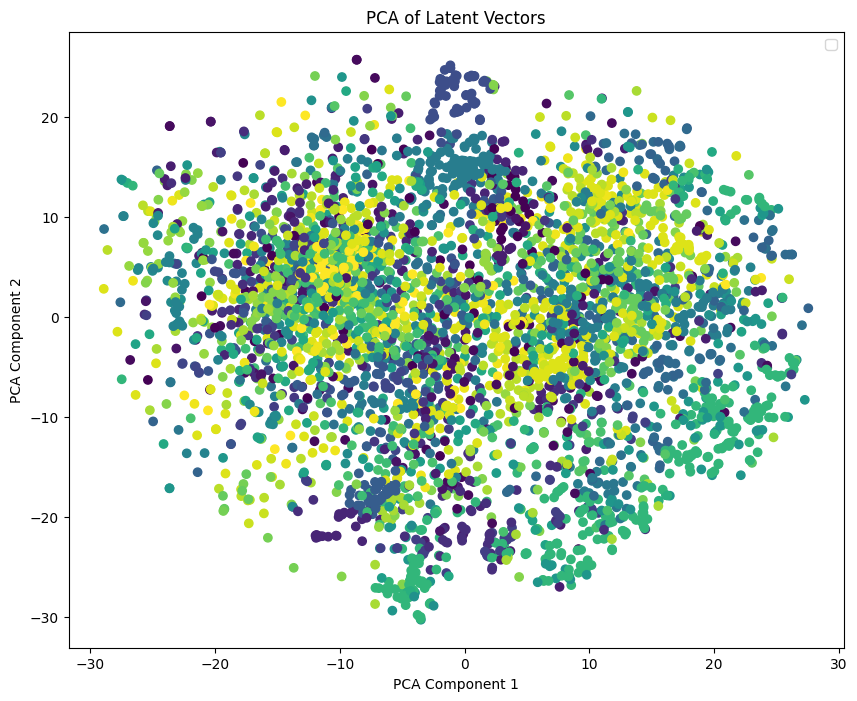

In [14]:
# Apply PCA
pca = TSNE(n_components=2, random_state=42)
pca_result = pca.fit_transform(latent_vectors)

# Plot the results
plt.figure(figsize=(10, 8))

scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Latent Vectors')
plt.legend()
plt.show()